In [29]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
import numpyro.distributions as dist
import blackjax

In [33]:
rng_key = jax.random.PRNGKey(0)

In [23]:
def model():
    mu_x = dist.Normal(0, 0.5).sample(key=rng_key)
    mu_y = dist.Normal(0, 0.5).sample(key=rng_key)

    x_i = dist.Normal(mu_x, 1).sample(rng_key, (100,))
    y_i = dist.Normal(mu_y, 1).sample(rng_key, (100,))

In [36]:
# observed data
x = dist.Normal(0, 1).sample(key=rng_key)
y = dist.Normal(0, 1).sample(key=rng_key)

In [35]:
def target_density(q, a=0, b=1, k=0, d=1):
    
    # q = list of params of d-dimension
    mu_y = q[0]
    mu_x = q[1]

    # priors
    log_probs_mu_x = dist.Normal(loc=a, scale=b).log_prob(mu_x)
    log_probs_mu_y = dist.Normal(loc=k, scale=d).log_prob(mu_y)

    # likelihood
    log_prob_y = jnp.sum(dist.Normal(loc=mu_y, scale=1).log_prob(y))
    log_prob_x = jnp.sum(dist.Normal(loc=mu_x, scale=1).log_prob(x))

    # posterior
    posterior = log_prob_x + log_prob_y + log_probs_mu_x + log_probs_mu_y

    return -posterior

In [31]:
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
hmc = blackjax.hmc(target_density, step_size, inverse_mass_matrix, 10)

In [85]:
# initialize the state
initial_pos = jnp.array([0., 0.])
state = hmc.init(initial_pos)

# iterate
samples = []
step = jax.jit(hmc.step)
for _ in range(500):
    _, rng_key = jax.random.split(rng_key)
    state, _ = step(rng_key, state)
    samples.append(state.position)

samples = jnp.array(samples)

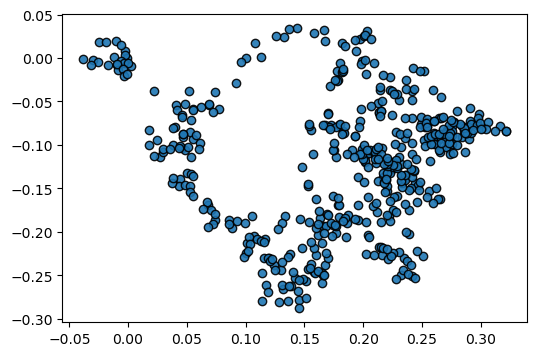

In [86]:
plt.figure(figsize=(6, 4))
plt.scatter(samples[:, 0], samples[:, 1], edgecolors='black', alpha=0.9);